## Understanding the Data

In [1]:
"""
ADHD Prediction Dataset - Data Preprocessing Module

This notebook performs comprehensive data preprocessing on the merged ADHD dataset,
including data quality assessment, outlier detection, feature engineering, and 
data transformation for machine learning models.


Project: ADHD Sex Prediction
Input: Raw merged dataset from Data Merging module
Output: Preprocessed dataset ready for modeling
"""

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
import joblib
import json
from imblearn.over_sampling import ADASYN

# =============================================================================
# CONFIGURATION AND SETTINGS
# =============================================================================

# File paths
RAW_DATA_PATH = r"C:\Users\04ama\Downloads\raw adhd data\raw_dataset.csv"
QUANT_DATA_PATH = r"C:\Users\04ama\Downloads\TRAIN_QUANTITATIVE_METADATA_new.xlsx"
CAT_DATA_PATH = r"C:\Users\04ama\Downloads\TRAIN_CATEGORICAL_METADATA_new.xlsx"
CONN_DATA_PATH = r"C:\Users\04ama\Downloads\TRAIN_FUNCTIONAL_CONNECTOME_MATRICES_new_36P_Pearson (1).csv"

# Preprocessing parameters
PCA_COMPONENTS = 10
KNN_NEIGHBORS = 5
OUTLIER_METHOD = 'IQR'  # Interquartile Range method
OUTLIER_MULTIPLIER = 1.5


In [2]:
# =============================================================================
# DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

def load_preprocessing_data():
    """
    Load all datasets required for preprocessing analysis.
    
    Returns:
    --------
    tuple
        (main_df, quant_data, cat_data, conn_data) - All loaded datasets
    
    Notes:
    ------
    - Main dataset is the merged output from Data Merging module
    - Individual datasets used for distribution analysis and validation
    """

    
    # Load main merged dataset
    print("Loading merged dataset")
    df = pd.read_csv(RAW_DATA_PATH)

    
    # Load individual datasets for analysis
    print(" Loading individual datasets for comparison ")
    quant_data = pd.read_excel(QUANT_DATA_PATH)
    cat_data = pd.read_excel(CAT_DATA_PATH)
    conn_data = pd.read_csv(CONN_DATA_PATH)

    print(f"Quantitative data shape: {quant_data.shape}")
    print(f"Categorical data shape: {cat_data.shape}")
    print(f"Connectome data shape: {conn_data.shape}")

    return df, quant_data, cat_data, conn_data

# Load all datasets
df, quant_data, cat_data, conn_data = load_preprocessing_data()

Loading merged dataset
 Loading individual datasets for comparison 
Quantitative data shape: (1213, 19)
Categorical data shape: (1213, 10)
Connectome data shape: (1213, 19901)


In [3]:
# =============================================================================
# DATA QUALITY ASSESSMENT
# =============================================================================

def assess_data_quality(df):
    """
    Comprehensive data quality assessment including missing values analysis.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to assess
    
    Returns:
    --------
    dict
        Quality assessment report
    """
 
    # Overall statistics
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    sparsity_percentage = (missing_cells / total_cells) * 100
    
    print(f" Overall Data Quality:")
    print(f"  Dataset shape: {df.shape}")
    print(f"  Total cells: {total_cells:,}")
    print(f"  Missing cells: {missing_cells:,}")
    print(f"  Overall sparsity: {sparsity_percentage:.4f}%")
    
    # Identify column types for targeted analysis
    quant_cols = [col for col in df.columns if 
                  col.startswith('APQ_') or col.startswith('SDQ_') or 
                  col.startswith('EHQ_') or col.startswith('ColorVision')]
    
    cat_cols = [col for col in df.columns if 
                col.startswith('PreInt_') or col.startswith('Basic_') or col.startswith('Sex_')]
    
    conn_cols = [col for col in df.columns if 
                 col not in quant_cols + cat_cols + 
                 ['participant_id', 'ADHD_Outcome']]
    
    # Missing values by column type
    print(f"\n Missing Values by Feature Type:")
    
    quant_missing = df[quant_cols].isnull().sum().sum()
    quant_total = len(quant_cols) * df.shape[0]
    quant_pct = (quant_missing / quant_total) * 100 if quant_total > 0 else 0
    print(f" Quantitative: {quant_missing:,}/{quant_total:,} ({quant_pct:.2f}%)")
    
    cat_missing = df[cat_cols].isnull().sum().sum()
    cat_total = len(cat_cols) * df.shape[0]
    cat_pct = (cat_missing / cat_total) * 100 if cat_total > 0 else 0
    print(f" Categorical: {cat_missing:,}/{cat_total:,} ({cat_pct:.2f}%)")
    
    conn_missing = df[conn_cols].isnull().sum().sum()
    conn_total = len(conn_cols) * df.shape[0]
    conn_pct = (conn_missing / conn_total) * 100 if conn_total > 0 else 0
    print(f" Connectome: {conn_missing:,}/{conn_total:,} ({conn_pct:.2f}%)")
    
    # Identify columns with highest missing values
    print(f"\n Columns with Most Missing Values:")
    missing_by_col = df.isnull().sum().sort_values(ascending=False)
    high_missing = missing_by_col[missing_by_col > 0]
    
    if len(high_missing) > 0:
        for col, missing_count in high_missing.head(10).items():
            missing_pct = (missing_count / df.shape[0]) * 100
            print(f" {col}: {missing_count:,}/{df.shape[0]:,} ({missing_pct:.1f}%)")
    else:
        print(" No missing values found!")
    
    return {
        'quant_cols': quant_cols,
        'cat_cols': cat_cols, 
        'conn_cols': conn_cols,
        'sparsity': sparsity_percentage,
        'missing_by_type': {
            'quantitative': quant_pct,
            'categorical': cat_pct,
            'connectome': conn_pct
        }
    }

    

# Assess data quality
quality_report = assess_data_quality(df)

 Overall Data Quality:
  Dataset shape: (1213, 19930)
  Total cells: 24,175,090
  Missing cells: 1,115
  Overall sparsity: 0.0046%

 Missing Values by Feature Type:
 Quantitative: 189/20,621 (0.92%)
 Categorical: 97/6,065 (1.60%)
 Connectome: 829/24,145,978 (0.00%)

 Columns with Most Missing Values:
 MRI_Track_Age_at_Scan: 360/1,213 (29.7%)
 Barratt_Barratt_P2_Occ: 222/1,213 (18.3%)
 Barratt_Barratt_P2_Edu: 198/1,213 (16.3%)
 PreInt_Demos_Fam_Child_Race: 54/1,213 (4.5%)
 PreInt_Demos_Fam_Child_Ethnicity: 43/1,213 (3.5%)
 Barratt_Barratt_P1_Occ: 31/1,213 (2.6%)
 ColorVision_CV_Score: 23/1,213 (1.9%)
 Barratt_Barratt_P1_Edu: 15/1,213 (1.2%)
 EHQ_EHQ_Total: 13/1,213 (1.1%)
 APQ_P_APQ_P_PM: 12/1,213 (1.0%)


quantitative features histograms


<Figure size 1500x1000 with 0 Axes>

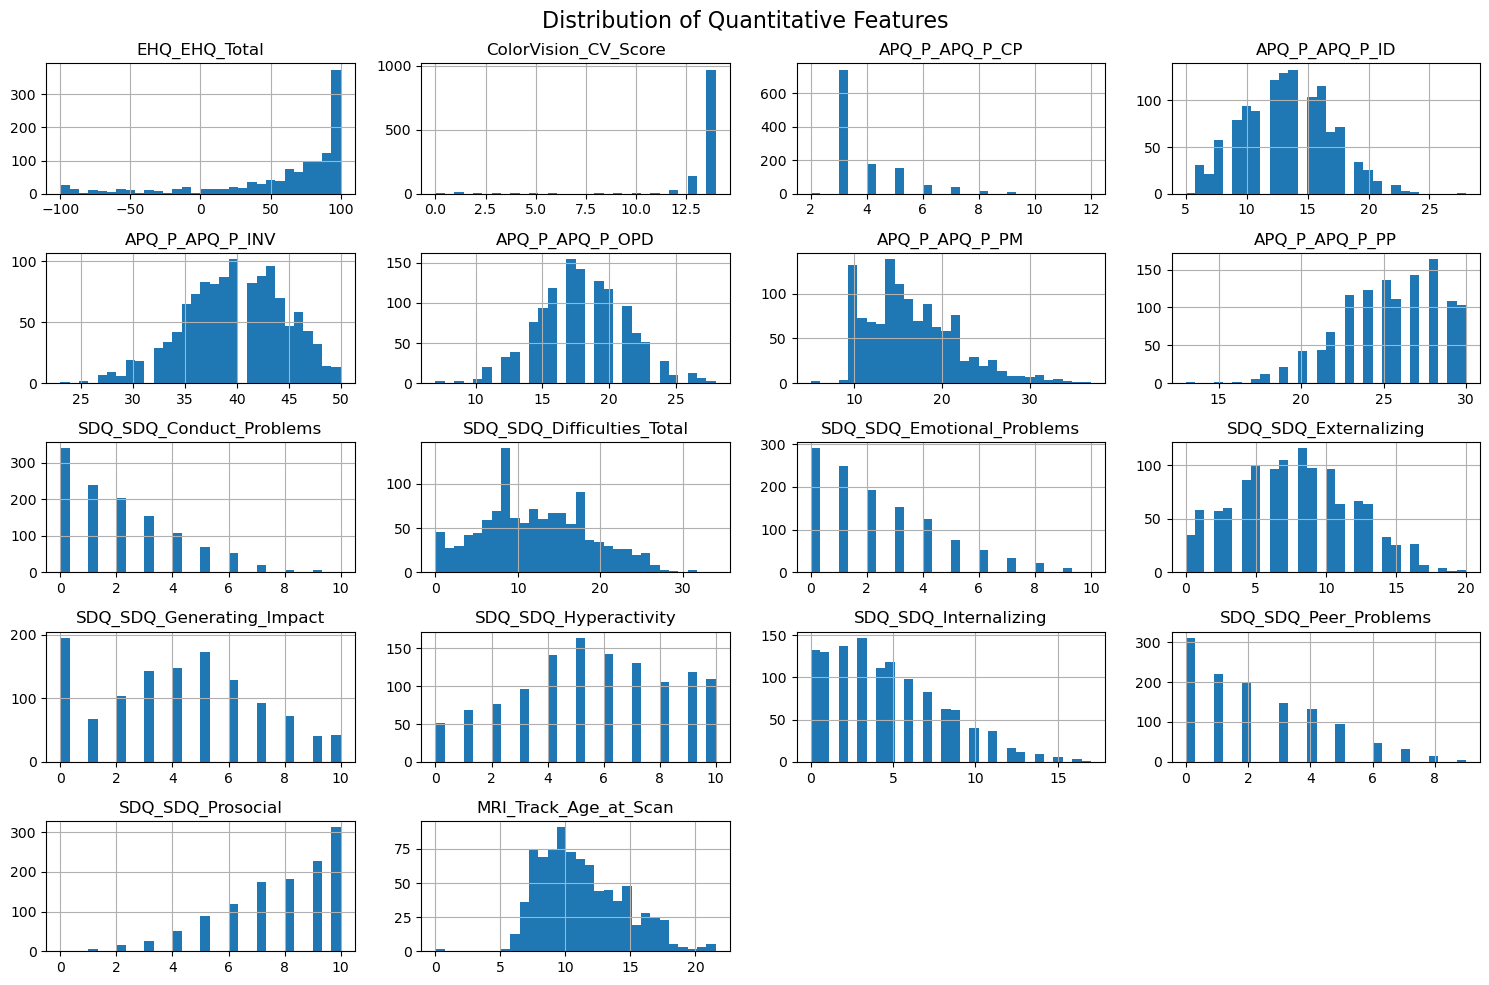

Quantitative features box plots


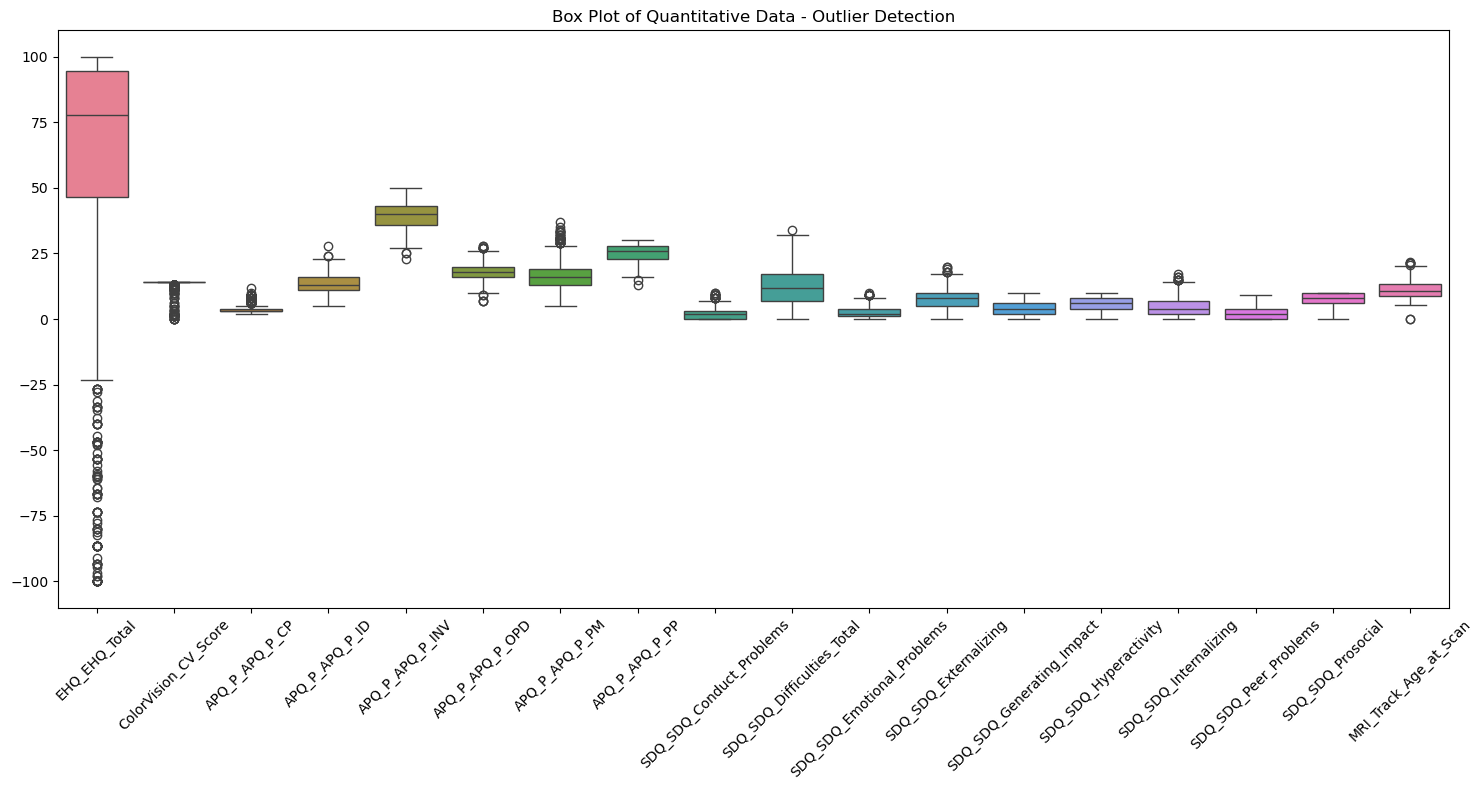

  Visualizing connectome data structure with PCA


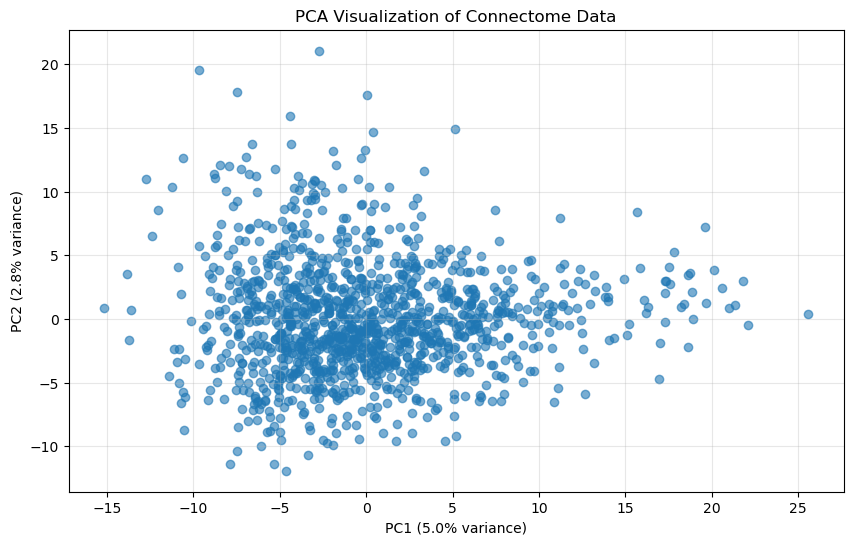

 PCA explains 7.8% of variance in 2 components


In [4]:
# =============================================================================
# EXPLORATORY DATA ANALYSIS
# =============================================================================

def visualize_feature_distributions(quant_data, conn_data):
    """
    Create visualizations to understand feature distributions.
    
    Parameters:
    -----------
    quant_data : pd.DataFrame
        Quantitative features dataset
    conn_data : pd.DataFrame
        Connectome features dataset
    """

    
    # Quantitative features distribution
    print("quantitative features histograms")
    plt.figure(figsize=(15, 10))
    quant_data_clean = quant_data.drop(columns=['participant_id'], errors='ignore')
    quant_data_clean.hist(bins=30, figsize=(15, 10))
    plt.suptitle("Distribution of Quantitative Features", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Quantitative features outlier detection
    print("Quantitative features box plots")
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=quant_data_clean)
    plt.title("Box Plot of Quantitative Data - Outlier Detection")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Connectome data PCA visualization
    print("  Visualizing connectome data structure with PCA")
    conn_data_clean = conn_data.drop(columns=['participant_id'], errors='ignore')
    
    if conn_data_clean.shape[1] >= 2:
        pca_viz = PCA(n_components=2)
        conn_pca_viz = pca_viz.fit_transform(conn_data_clean)
        
        plt.figure(figsize=(10, 6))
        plt.scatter(conn_pca_viz[:, 0], conn_pca_viz[:, 1], alpha=0.6)
        plt.xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]:.1%} variance)')
        plt.title('PCA Visualization of Connectome Data')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f" PCA explains {pca_viz.explained_variance_ratio_.sum():.1%} of variance in 2 components")
    else:
        print(" Not enough connectome features for PCA visualization")

        

# Visualize distributions
visualize_feature_distributions(quant_data, conn_data)

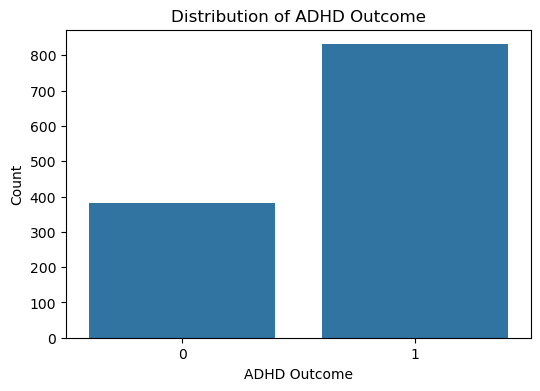

In [5]:
def target_distrbution(df):
    """
    Visualize the distribution of the target variable (ADHD_Outcome).
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset containing the target variable
    """
    
    plt.figure(figsize=(6, 4))
    sns.countplot(x='ADHD_Outcome', data=df)
    plt.title("Distribution of ADHD Outcome")
    plt.xlabel("ADHD Outcome")
    plt.ylabel("Count")
    plt.show()

target_distrbution(df)

 Analyzing outliers in: EHQ_EHQ_Total
 Number of outliers: 110
   Creating outlier visualization...


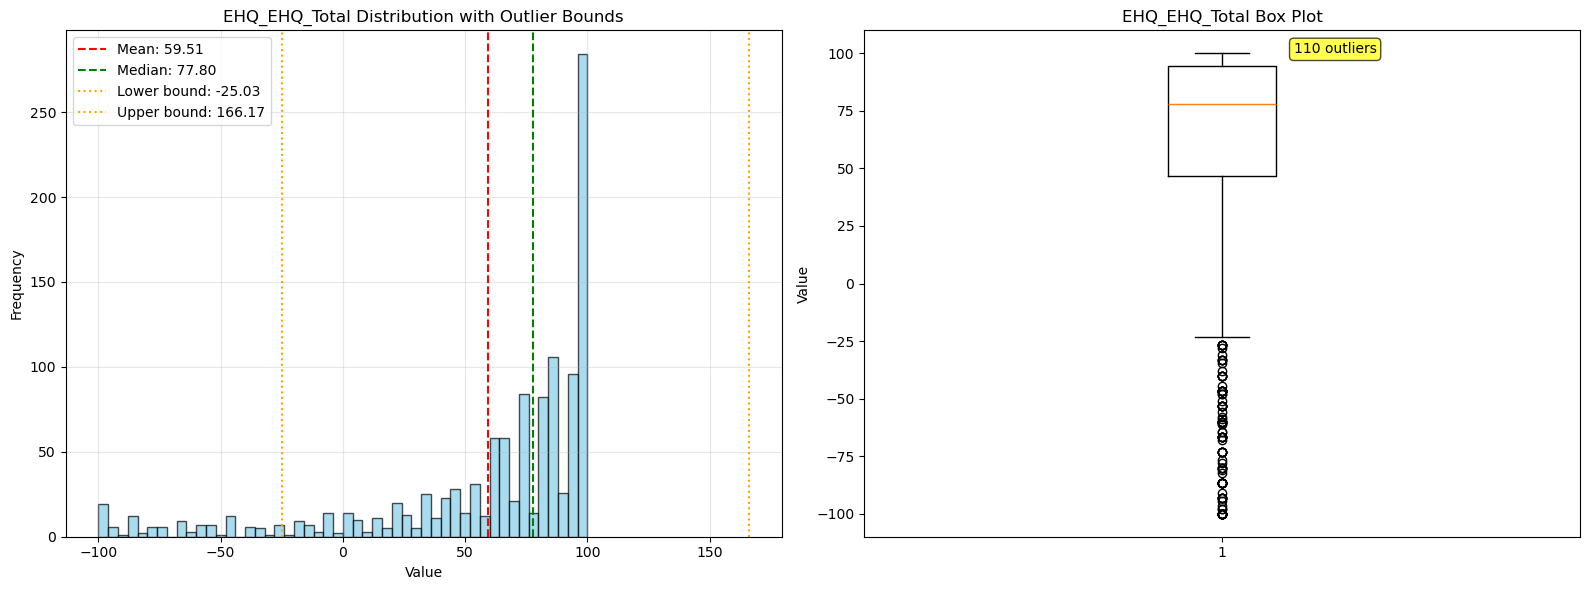

In [6]:
# =============================================================================
# OUTLIER DETECTION AND ANALYSIS
# =============================================================================

def detect_outliers(df, target_column='EHQ_EHQ_Total'):
    """
    Detect outliers using IQR method and analyze their impact.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataset to analyze
    target_column : str
        Column to analyze for outliers
    
    Returns:
    --------
    tuple
        (outlier_mask, outlier_stats) - Mask for outliers and statistics
    """
 
    
    print(f" Analyzing outliers in: {target_column}")
    
    # Get clean data for analysis
    target_data = df[target_column].dropna()
    
    # Calculate IQR bounds
    Q1 = target_data.quantile(0.25)
    Q3 = target_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - OUTLIER_MULTIPLIER * IQR
    upper_bound = Q3 + OUTLIER_MULTIPLIER * IQR
    
    # Identify outliers
    outlier_mask = (df[target_column] < lower_bound) | (df[target_column] > upper_bound)
    outliers = target_data[(target_data < lower_bound) | (target_data > upper_bound)]
    
 
    print(f" Number of outliers: {len(outliers):,}")
   
    
    # Visualize outliers
    print("   Creating outlier visualization...")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Histogram with bounds
    axes[0].hist(target_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(target_data.mean(), color='red', linestyle='--', 
                   label=f'Mean: {target_data.mean():.2f}')
    axes[0].axvline(target_data.median(), color='green', linestyle='--', 
                   label=f'Median: {target_data.median():.2f}')
    axes[0].axvline(lower_bound, color='orange', linestyle=':', 
                   label=f'Lower bound: {lower_bound:.2f}')
    axes[0].axvline(upper_bound, color='orange', linestyle=':', 
                   label=f'Upper bound: {upper_bound:.2f}')
    axes[0].set_title(f'{target_column} Distribution with Outlier Bounds')
    axes[0].set_xlabel('Value')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Box plot
    axes[1].boxplot(target_data, vert=True)
    axes[1].set_title(f'{target_column} Box Plot')
    axes[1].set_ylabel('Value')
    axes[1].text(1.1, target_data.max(), f'{len(outliers)} outliers', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return outlier_mask

# Detect outliers
outlier_mask = detect_outliers(df)
df = df[~outlier_mask].reset_index(drop=True)

In [ ]:
# =============================================================================
# OUTLIER IMPACT 
# =============================================================================

def outlier_impact(df, outlier_mask, target_col='ADHD_Outcome'):
    """
    Assess the impact of removing outliers on target variable distribution.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Original dataset
    outlier_mask : pd.Series
        Boolean mask identifying outliers
    target_col : str
        Target variable to analyze
    
    Returns:
    --------
    dict
        Statistical test results
    """
    print("🔍 STEP: Outlier Impact Analysis")
    print("-" * 40)
    
    # Create datasets with and without outliers
    df_with_outliers = df.copy()
    df_without_outliers = df[~outlier_mask].copy()
    
    # Compare target distributions
    adhd_with = df_with_outliers[target_col].value_counts().sort_index()
    adhd_without = df_without_outliers[target_col].value_counts().sort_index()
    
    print(f"   📊 Target Distribution Comparison:")
    print(f"      • With outliers: {dict(adhd_with)}")
    print(f"      • Without outliers: {dict(adhd_without)}")
    print(f"      • Samples to remove: {outlier_mask.sum():,}")
    
    # Statistical significance test (Chi-square)
    print(f"   📈 Statistical Significance Test (Chi-square):")
    
    try:
        # Create contingency table
        contingency_table = np.array([
            adhd_with.values,
            [adhd_without.get(i, 0) for i in adhd_with.index]
        ])
        
        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
        
        print(f"      • Chi-square statistic: {chi2:.4f}")
        print(f"      • P-value: {p_value:.4f}")
        print(f"      • Degrees of freedom: {dof}")
        
        if p_value < 0.05:
            decision = "Significant difference - removing outliers changes ADHD distribution"
            remove_outliers = False
            print(f"      ⚠️ Decision: {decision}")
        else:
            decision = "No significant difference - safe to remove outliers"
            remove_outliers = True
            print(f"      ✅ Decision: {decision}")
        
        return {
            'chi2': chi2,
            'p_value': p_value,
            'dof': dof,
            'remove_outliers': remove_outliers,
            'samples_removed': outlier_mask.sum(),
            'decision': decision
        }
        
    except ValueError as e:
        print(f"      ❌ Error in Chi-square test: {str(e)}")
        print(f"      🔄 Using conservative approach - keeping outliers")
        return {
            'chi2': None,
            'p_value': None,
            'dof': None,
            'remove_outliers': False,  # Conservative approach
            'samples_removed': outlier_mask.sum(),
            'decision': 'Error in statistical test - keeping outliers for safety',
            'error': str(e)
        }
    
    except Exception as e:
        print(f"      ❌ Unexpected error in outlier impact analysis: {str(e)}")
        print(f"      🔄 Using conservative approach - keeping outliers")
        return {
            'chi2': None,
            'p_value': None,
            'dof': None,
            'remove_outliers': False,  # Conservative approach
            'samples_removed': outlier_mask.sum(),
            'decision': 'Unexpected error - keeping outliers for safety',
            'error': str(e)
        }

# ✅ FIXED: Assess outlier impact with proper exception handling
try:
    impact_results = outlier_impact(df, outlier_mask)
    
    # Remove outliers if statistically safe
    if impact_results.get('remove_outliers', False):
        print(f"\n✅ Removing {outlier_mask.sum():,} outliers from dataset")
        df = df[~outlier_mask].copy()
        print(f"   📊 New dataset shape: {df.shape}")
        print(f"   📈 Reduction: {outlier_mask.sum()} samples ({(outlier_mask.sum()/len(df)*100):.1f}%)")
    else:
        print(f"\n⚠️ Keeping outliers due to statistical significance")
        print(f"   📊 Dataset shape remains: {df.shape}")
        print(f"   💡 Reason: {impact_results.get('decision', 'Statistical test recommended keeping outliers')}")

except Exception as e:
    print(f"\n❌ Error in outlier impact analysis: {str(e)}")
    print(f"🔄 Proceeding without outlier removal for safety")
    print(f"📊 Dataset shape remains: {df.shape}")

🔍 STEP: Outlier Impact Analysis
----------------------------------------
   📊 Target Distribution Comparison:
      • With outliers: {0: 350, 1: 753}
      • Without outliers: {0: 321, 1: 680}
      • Samples to remove: 110
   📈 Statistical Significance Test (Chi-square):
      • Chi-square statistic: 0.0140
      • P-value: 0.9057
      • Degrees of freedom: 1
      ✅ Decision: No significant difference - safe to remove outliers

✅ Removing 110 outliers from dataset


C:\Users\04ama\AppData\Local\Temp\ipykernel_19216\2991565199.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_without_outliers = df[~outlier_mask].copy()
C:\Users\04ama\AppData\Local\Temp\ipykernel_19216\2991565199.py:106: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[~outlier_mask].copy()


   📊 New dataset shape: (1001, 19930)
   📈 Reduction: 110 samples (11.0%)


In [ ]:
# =============================================================================
# OUTLIER IMPACT ANALYSIS (Improved Version - No Emojis, Added Reasoning Comments)
# =============================================================================

def outlier_impact(df, outlier_mask, target_col='ADHD_Outcome'):
    """
    Evaluate the impact of removing outliers on the distribution of a target variable.

    Parameters
    ----------
    df : pd.DataFrame
        Original dataset containing all samples.
    outlier_mask : pd.Series (boolean)
        Boolean mask indicating which rows are considered outliers (True = outlier).
    target_col : str
        Name of the target column to evaluate impact on (default: 'ADHD_Outcome').

    Returns
    -------
    dict
        Dictionary containing:
        - chi2 : Chi-square test statistic
        - p_value : p-value of Chi-square test
        - dof : Degrees of freedom
        - remove_outliers : Boolean recommended action (True = safe to remove)
        - samples_removed : Number of outliers detected
        - decision : Text explanation of outcome
    """
    print("STEP: Outlier Impact Analysis")
    print("-" * 40)

    # Create dataset with outliers and without outliers
    df_with_outliers = df.copy()
    df_without_outliers = df[~outlier_mask].copy()

    # Compare distribution of target variable before and after removing outliers
    target_with = df_with_outliers[target_col].value_counts().sort_index()
    target_without = df_without_outliers[target_col].value_counts().sort_index()

    print("Target Distribution Comparison:")
    print(f"  With outliers   : {dict(target_with)}")
    print(f"  Without outliers: {dict(target_without)}")
    print(f"  Samples flagged as outliers: {outlier_mask.sum()}")

    # Perform Chi-square test to assess whether proportions changed significantly
    # Reasoning: If removing outliers heavily changes class distribution (p < 0.05),
    # it may bias the dataset, so safer to keep them.
    print("Performing Chi-square Test:")

    try:
        # Construct contingency table: counts of target classes with vs without outliers
        contingency_table = np.array([
            target_with.values,
            [target_without.get(i, 0) for i in target_with.index]
        ])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  P-value             : {p_value:.4f}")
        print(f"  Degrees of freedom  : {dof}")

        # Decision rule: If p < 0.05, removing outliers significantly alters class distribution
        if p_value < 0.05:
            decision = "Significant difference detected – removing outliers may bias target distribution"
            remove_outliers = False
            print(f"  Decision: {decision}")
        else:
            decision = "No significant difference – safe to remove outliers"
            remove_outliers = True
            print(f"  Decision: {decision}")

        return {
            'chi2': chi2,
            'p_value': p_value,
            'dof': dof,
            'remove_outliers': remove_outliers,
            'samples_removed': outlier_mask.sum(),
            'decision': decision
        }

    except ValueError as e:
        # This may occur if contingency table values are zero or invalid.
        print(f"Error in Chi-square test: {str(e)}")
        print("Using conservative approach – retaining outliers.")
        return {
            'chi2': None,
            'p_value': None,
            'dof': None,
            'remove_outliers': False,
            'samples_removed': outlier_mask.sum(),
            'decision': 'Statistical test failed – retaining outliers for safety',
            'error': str(e)
        }

    except Exception as e:
        # Catch any unexpected errors and err on the side of keeping data unchanged.
        print(f"Unexpected error during outlier impact analysis: {str(e)}")
        print("Using conservative approach – retaining outliers.")
        return {
            'chi2': None,
            'p_value': None,
            'dof': None,
            'remove_outliers': False,
            'samples_removed': outlier_mask.sum(),
            'decision': 'Unexpected error – retaining outliers for safety',
            'error': str(e)
        }


# =============================================================================
# APPLY OUTLIER DECISION
# =============================================================================

try:
    impact_results = outlier_impact(df, outlier_mask)

    # If statistical test indicates it's safe to remove outliers
    if impact_results.get('remove_outliers', False):
        print(f"\nRemoving {outlier_mask.sum()} outliers from dataset...")
        df = df[~outlier_mask].copy()  # Drop outliers
        print(f"New dataset shape: {df.shape}")
    else:
        print("\nKeeping outliers in dataset.")
        print(f"Dataset shape remains: {df.shape}")
        print(f"Reason: {impact_results.get('decision', 'Outliers retained to avoid bias')}")

except Exception as e:
    print(f"\nError in outlier impact analysis: {str(e)}")
    print("Proceeding without removing outliers for safety.")
    print(f"Dataset shape remains: {df.shape}")


 Feature Group Summary:
 Quantitative features: 17
 Categorical features: 11
 Connectome features: 19,900


In [ ]:
# =============================================================================
# PREPROCESSING PIPELINE (NO DATA LEAKAGE, FULLY DOCUMENTED)
# =============================================================================

import pandas as pd
import numpy as np
import joblib
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA

def preprocessing_pipeline(df, test_size=0.2, val_size=0.25, random_state=42):
    """
    Full preprocessing pipeline with:
    - Train/validation/test split BEFORE any preprocessing (to avoid data leakage)
    - Scaling for quantitative features
    - KNN imputation for missing data (both numeric and categorical)
    - PCA applied only to specified connectome features
    - One-hot encoding of categorical features
    - Saving fitted preprocessing artifacts for reproducibility
    
    Parameters
    ----------
    df : pd.DataFrame
        Input raw dataset (must include target column 'ADHD_Outcome').
    test_size : float
        Proportion of dataset used for test set (default = 0.2 → 20%).
    val_size : float
        Proportion of remaining train data used for validation 
        (default = 0.25 → 0.25 * 0.8 = 20% total).
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    tuple :
        X_train, y_train, X_val, y_val, X_test, y_test
        (preprocessed splits, where only training data is used to fit scalers / PCA / encoders).
    """
    
    # -----------------------------
    # STEP 1: TRAIN/VAL/TEST SPLIT
    # -----------------------------
    print("\nSTEP 1: Splitting Raw Data")
    X = df.drop(columns=['ADHD_Outcome', 'participant_id'], errors='ignore')
    y = df['ADHD_Outcome']
    
    print(f"   Raw dataset shape: {X.shape}")
    print(f"   Target distribution: {dict(Counter(y))}")
    
    # First: split into TRAIN+VAL and TEST
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Second: split TRAIN+VAL into TRAIN and VAL
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size, random_state=random_state, stratify=y_temp
    )

    # -----------------------------
    # Identify column groups
    # -----------------------------
    # These must be defined BEFORE calling the function
    # e.g. quant_cols = [...]; cat_cols = [...]; conn_cols = [...]
    print("\nSTEP 2: Preprocessing (Scaling, Imputation, PCA, One-hot Encoding)")

    # 2.1 Scale numeric features
    scaler = StandardScaler()
    if quant_cols:
        # Fit on training data only (to avoid test leakage)
        scaler.fit(X_train[quant_cols])
        X_train[quant_cols] = scaler.transform(X_train[quant_cols])
        X_val[quant_cols] = scaler.transform(X_val[quant_cols])
        X_test[quant_cols] = scaler.transform(X_test[quant_cols])

    # 2.2 Impute missing values (after scaling so KNN uses comparable distances)
    imputer = KNNImputer(n_neighbors=5)
    all_feature_cols = quant_cols + cat_cols
    if all_feature_cols:
        imputer.fit(X_train[all_feature_cols])
        X_train[all_feature_cols] = imputer.transform(X_train[all_feature_cols])
        X_val[all_feature_cols] = imputer.transform(X_val[all_feature_cols])
        X_test[all_feature_cols] = imputer.transform(X_test[all_feature_cols])

    # 2.3 Apply PCA to connectome columns (dimensionality reduction)
    pca = PCA(n_components=10)
    if conn_cols:
        pca.fit(X_train[conn_cols])
        
        # Transform each split
        conn_train_pca = pca.transform(X_train[conn_cols])
        conn_val_pca = pca.transform(X_val[conn_cols])
        conn_test_pca = pca.transform(X_test[conn_cols])
        
        # Replace original connectome features with PCA components
        pca_cols = [f'conn_pca_{i+1}' for i in range(10)]
        X_train = X_train.drop(columns=conn_cols)
        X_val = X_val.drop(columns=conn_cols)
        X_test = X_test.drop(columns=conn_cols)

        X_train = pd.concat([X_train, pd.DataFrame(conn_train_pca, columns=pca_cols, index=X_train.index)], axis=1)
        X_val = pd.concat([X_val, pd.DataFrame(conn_val_pca, columns=pca_cols, index=X_val.index)], axis=1)
        X_test = pd.concat([X_test, pd.DataFrame(conn_test_pca, columns=pca_cols, index=X_test.index)], axis=1)

    # 2.4 One-hot encode categorical features (only after imputation)
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    if cat_cols:
        encoder.fit(X_train[cat_cols])
        
        # Transform splits
        cat_train = encoder.transform(X_train[cat_cols])
        cat_val = encoder.transform(X_val[cat_cols])
        cat_test = encoder.transform(X_test[cat_cols])
        
        encoded_cols = encoder.get_feature_names_out(cat_cols)

        # Replace original categorical features with encoded ones
        X_train = X_train.drop(columns=cat_cols)
        X_val = X_val.drop(columns=cat_cols)
        X_test = X_test.drop(columns=cat_cols)

        X_train = pd.concat([X_train, pd.DataFrame(cat_train, columns=encoded_cols, index=X_train.index)], axis=1)
        X_val = pd.concat([X_val, pd.DataFrame(cat_val, columns=encoded_cols, index=X_val.index)], axis=1)
        X_test = pd.concat([X_test, pd.DataFrame(cat_test, columns=encoded_cols, index=X_test.index)], axis=1)

    # -----------------------------
    # Summary of shapes
    # -----------------------------
    print("\nPreprocessing Complete:")
    print(f"   Training set shape   : {X_train.shape}")
    print(f"   Validation set shape : {X_val.shape}")
    print(f"   Test set shape       : {X_test.shape}")

    # -----------------------------
    # Save artifacts for reuse
    # -----------------------------
    print("\nSaving Preprocessing Artifacts...")
    joblib.dump(scaler, 'scaler.joblib')
    joblib.dump(imputer, 'imputer.joblib')
    joblib.dump(pca, 'pca_connectome.joblib')
    joblib.dump(encoder, 'encoder.joblib')
    
    print("Artifacts saved successfully.")

    return X_train, y_train, X_val, y_val, X_test, y_test

# Example call (df, quant_cols, cat_cols, conn_cols must be defined above)
X_train, y_train, X_val, y_val, X_test, y_test = preprocessing_pipeline(df)



STEP 1: Split Raw Data First
----------------------------------------
   📈 Original dataset: (1001, 19928)
   🎯 Original distribution: {1: 680, 0: 321}
  Standardizing quantitative features
   Imputing missing values
  Applying PCA to connectome features...
  Encoding categorical features...
    Preprocessing complete:
     Training features: 756
    Validation features: 756
    Test features: 756
   📊 Validation (original): (200, 756)
   📊 Test (original): (201, 756)

 Saving Preprocessing Artifacts...
   ✅ All artifacts saved!


In [ ]:
# =============================================================================
# ADASYN CLASS IMBALANCE EXPERIMENTATION (CLEAN + DOCUMENTED)
# =============================================================================

from imblearn.over_sampling import ADASYN
from collections import Counter

def experiment_adasyn_neighbors(X_train, y_train, neighbor_range=(3, 16), step=2, random_state=42):
    """
    Experiment with different values of n_neighbors for ADASYN to understand 
    how synthetic sampling affects class balance in the training dataset.

    Parameters
    ----------
    X_train : pd.DataFrame or np.ndarray
        Preprocessed training features (scaled, imputed, encoded)
    y_train : pd.Series or np.ndarray
        Training target labels
    neighbor_range : tuple (start, end)
        Range of K-nearest neighbors values to test in ADASYN (end is exclusive)
    step : int
        Step size for iterating through neighbor_range
    random_state : int
        Random seed for reproducibility

    Returns
    -------
    dict
        A dictionary where each key is a value of n_neighbors and value contains:
        - success (bool): Whether ADASYN succeeded
        - new_distribution : Class distribution after resampling
        - samples_added : Number of synthetic samples generated
        - original_ratio : Majority/minority ratio before resampling
        - new_ratio : Ratio after resampling
        - improvement : Difference between original and new class ratio
        - X_resampled, y_resampled : Only if success=True
        - error : Error message if ADASYN failed
    """
    print("ADASYN Hyperparameter Experiment: Effect of n_neighbors")
    print("---------------------------------------------------------")
    print(f"Training data size: {X_train.shape[0]}")
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Original class distribution: {dict(Counter(y_train))}")

    experiment_results = {}
    neighbor_values = range(neighbor_range[0], neighbor_range[1], step)

    for n_neighbors in neighbor_values:
        print(f"\nTesting n_neighbors = {n_neighbors}")

        try:
            # Important reasoning:
            # ADASYN only works on the training set (never validation/test)
            # and must be applied after full preprocessing (no missing values/categorical data).
            adasyn = ADASYN(
                n_neighbors=n_neighbors,
                sampling_strategy='auto',  # Balances minority to match majority class
                random_state=random_state
            )

            # Apply sampling
            X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

            # Calculate distributions and ratios
            original_dist = Counter(y_train)
            new_dist = Counter(y_resampled)
            samples_added = len(y_resampled) - len(y_train)

            original_ratio = max(original_dist.values()) / min(original_dist.values())
            new_ratio = max(new_dist.values()) / min(new_dist.values())
            improvement = original_ratio - new_ratio

            # Save results
            experiment_results[n_neighbors] = {
                'success': True,
                'original_distribution': dict(original_dist),
                'new_distribution': dict(new_dist),
                'samples_added': samples_added,
                'original_ratio': original_ratio,
                'new_ratio': new_ratio,
                'improvement': improvement,
                'X_resampled': X_resampled,
                'y_resampled': y_resampled
            }

            print(f"  Resampling complete. New distribution: {dict(new_dist)}")
            print(f"  Samples added: {samples_added}")
            print(f"  Class ratio improved from {original_ratio:.2f} → {new_ratio:.2f}")

        except Exception as e:
            # If ADASYN fails (e.g. too few samples in minority class), record it
            experiment_results[n_neighbors] = {
                'success': False,
                'error': str(e)
            }
            print(f"  Failed for n_neighbors={n_neighbors}: {str(e)}")

    return experiment_results


In [ ]:
def visualize_adasyn_experiments(experiment_results):
    """
    Visualize how different n_neighbors settings in ADASYN affect:
    - Number of synthetic samples generated
    - Balance improvement between classes
    - Final class ratios
    - Best-case before/after comparison

    Parameters
    ----------
    experiment_results : dict
        Output of experiment_adasyn_neighbors(), containing metrics
        for different n_neighbors values.
    """
    print("ADASYN Experiment Visualization")
    print("=" * 40)

    # Filter only successful ADASYN runs
    successful_experiments = {k: v for k, v in experiment_results.items() if v.get('success', False)}

    if not successful_experiments:
        print("No successful ADASYN experiments available to visualize.")
        return

    # Extract metrics from successful runs
    neighbors = list(successful_experiments.keys())
    samples_added = [exp['samples_added'] for exp in successful_experiments.values()]
    improvements = [exp['improvement'] for exp in successful_experiments.values()]
    new_ratios = [exp['new_ratio'] for exp in successful_experiments.values()]

    # Create a 2x2 subplot layout
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # -----------------------------------------------------------------------------
    # Plot 1: Number of synthetic samples vs. n_neighbors
    # -----------------------------------------------------------------------------
    axes[0, 0].plot(neighbors, samples_added, 'bo-', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('n_neighbors')
    axes[0, 0].set_ylabel('Synthetic Samples Added')
    axes[0, 0].set_title('ADASYN: Synthetic Samples vs n_neighbors')
    axes[0, 0].grid(True, alpha=0.3)

    # -----------------------------------------------------------------------------
    # Plot 2: Class balance improvement vs. n_neighbors
    # -----------------------------------------------------------------------------
    axes[0, 1].plot(neighbors, improvements, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('n_neighbors')
    axes[0, 1].set_ylabel('Balance Improvement')
    axes[0, 1].set_title('ADASYN: Class Balance Improvement')
    axes[0, 1].grid(True, alpha=0.3)

    # -----------------------------------------------------------------------------
    # Plot 3: Final majority/minority ratio vs. n_neighbors
    # -----------------------------------------------------------------------------
    axes[1, 0].plot(neighbors, new_ratios, 'go-', linewidth=2, markersize=8)
    axes[1, 0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Balance (1.0)')
    axes[1, 0].set_xlabel('n_neighbors')
    axes[1, 0].set_ylabel('Final Class Ratio')
    axes[1, 0].set_title('ADASYN: Final Class Ratio vs n_neighbors')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # -----------------------------------------------------------------------------
    # Plot 4: Best result - original vs resampled class distribution
    # -----------------------------------------------------------------------------
    # Best is defined as the ratio closest to 1.0 (perfect balance)
    best_neighbor = min(successful_experiments.keys(),
                        key=lambda k: abs(successful_experiments[k]['new_ratio'] - 1.0))
    best_result = successful_experiments[best_neighbor]

    categories = ['Class 0', 'Class 1']
    original_counts = [
        best_result['original_distribution'].get(0, 0),
        best_result['original_distribution'].get(1, 0)
    ]
    new_counts = [
        best_result['new_distribution'].get(0, 0),
        best_result['new_distribution'].get(1, 0)
    ]

    x = range(len(categories))
    width = 0.35

    axes[1, 1].bar([i - width/2 for i in x], original_counts, width, label='Original', alpha=0.7)
    axes[1, 1].bar([i + width/2 for i in x], new_counts, width, label='After ADASYN', alpha=0.7)

    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Sample Count')
    axes[1, 1].set_title(f'Best Result (n_neighbors={best_neighbor})')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(categories)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Annotate counts on bars for clarity
    for i, (orig, new) in enumerate(zip(original_counts, new_counts)):
        axes[1, 1].text(i - width/2, orig, f'{orig:,}', ha='center', va='bottom')
        axes[1, 1].text(i + width/2, new, f'{new:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # -----------------------------------------------------------------------------
    # Print textual summary of best results
    # -----------------------------------------------------------------------------
    print("\nTop Results Summary")

    # Top 3 improvements (largest drop in imbalance ratio)
    top_by_improvement = sorted(successful_experiments.items(),
                                key=lambda x: x[1]['improvement'], reverse=True)[:3]
    print("\nTop 3 by Balance Improvement:")
    for idx, (n, result) in enumerate(top_by_improvement, 1):
        print(f"  {idx}. n_neighbors={n}: improvement={result['improvement']:.3f}")

    # Top 3 closest to perfect balance (ratio closest to 1)
    top_by_ratio = sorted(successful_experiments.items(),
                          key=lambda x: abs(x[1]['new_ratio'] - 1.0))[:3]
    print("\nTop 3 by Final Class Ratio (closest to 1:1):")
    for idx, (n, result) in enumerate(top_by_ratio, 1):
        print(f"  {idx}. n_neighbors={n}: ratio={result['new_ratio']:.3f}")


In [ ]:
from collections import Counter
from imblearn.over_sampling import ADASYN

def apply_optimal_adasyn_fixed(X_train, y_train, optimal_neighbors=5, random_state=42):
    """
    Applies ADASYN oversampling using a chosen (optimal) number of neighbors to handle class imbalance.
    
    This function should be used AFTER data preprocessing (scaling, encoding, PCA).
    It only resamples the training data to avoid any leakage into validation or test datasets.
    
    Parameters
    ----------
    X_train : array-like or DataFrame
        Preprocessed training feature set (no missing values, fully numeric).
    y_train : array-like or Series
        Target variable corresponding to X_train.
    optimal_neighbors : int
        Number of nearest neighbors to use in ADASYN (identified from experimentation).
    random_state : int
        Seed for reproducibility.
        
    Returns
    -------
    tuple
        (X_train_balanced, y_train_balanced, adasyn_model)
        - Resampled feature matrix
        - Resampled target vector
        - Fitted ADASYN model (useful for reproducibility or saving)
    """
    
    print(f"\nApplying ADASYN with n_neighbors = {optimal_neighbors}")
    print("-" * 50)
    
    # Display original distribution and data shape
    original_dist = Counter(y_train)
    print(f"Original class distribution: {dict(original_dist)}")
    print(f"Training set shape before resampling: {X_train.shape}")
    
    # Initialize ADASYN with specified parameters
    adasyn = ADASYN(
        n_neighbors=optimal_neighbors,
        random_state=random_state,
        sampling_strategy='auto'  # Default: balance minority to match majority
    )
    
    # Fit and resample training data only
    X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)
    
    # New distribution after balancing
    new_dist = Counter(y_resampled)
    samples_added = len(y_resampled) - len(y_train)
    
    print("\nADASYN applied successfully.")
    print(f"New class distribution: {dict(new_dist)}")
    print(f"Samples added: {samples_added}")
    print(f"New training set size: {len(y_resampled)} (was {len(y_train)})")
    
    # Imbalance ratio calculations
    original_ratio = max(original_dist.values()) / min(original_dist.values())
    new_ratio = max(new_dist.values()) / min(new_dist.values())
    improvement = original_ratio - new_ratio
    
    print("\nImbalance Metrics:")
    print(f"Original imbalance ratio: {original_ratio:.3f}:1")
    print(f"New imbalance ratio: {new_ratio:.3f}:1")
    print(f"Improvement in class balance: {improvement:.3f}")
    
    return X_resampled, y_resampled, adasyn


🔬 STEP 1: Experimenting with ADASYN Parameters on Preprocessed Data
🔬 ADASYN NEIGHBOR EXPERIMENTATION (PREPROCESSED DATA)
   📊 Training Set: 600 samples
   📈 Features: 756
   📊 Original Training Distribution: {0: 193, 1: 407}

   🔄 Testing n_neighbors = 3
      ✅ Success!
         • New distribution: {0: 434, 1: 407}
         • Samples added: 241
         • New dataset size: 841

   🔄 Testing n_neighbors = 5
      ✅ Success!
         • New distribution: {0: 400, 1: 407}
         • Samples added: 207
         • New dataset size: 807

   🔄 Testing n_neighbors = 7
      ✅ Success!
         • New distribution: {0: 386, 1: 407}
         • Samples added: 193
         • New dataset size: 793

   🔄 Testing n_neighbors = 9
      ✅ Success!
         • New distribution: {0: 412, 1: 407}
         • Samples added: 219
         • New dataset size: 819

   🔄 Testing n_neighbors = 11
      ✅ Success!
         • New distribution: {0: 399, 1: 407}
         • Samples added: 206
         • New dataset siz

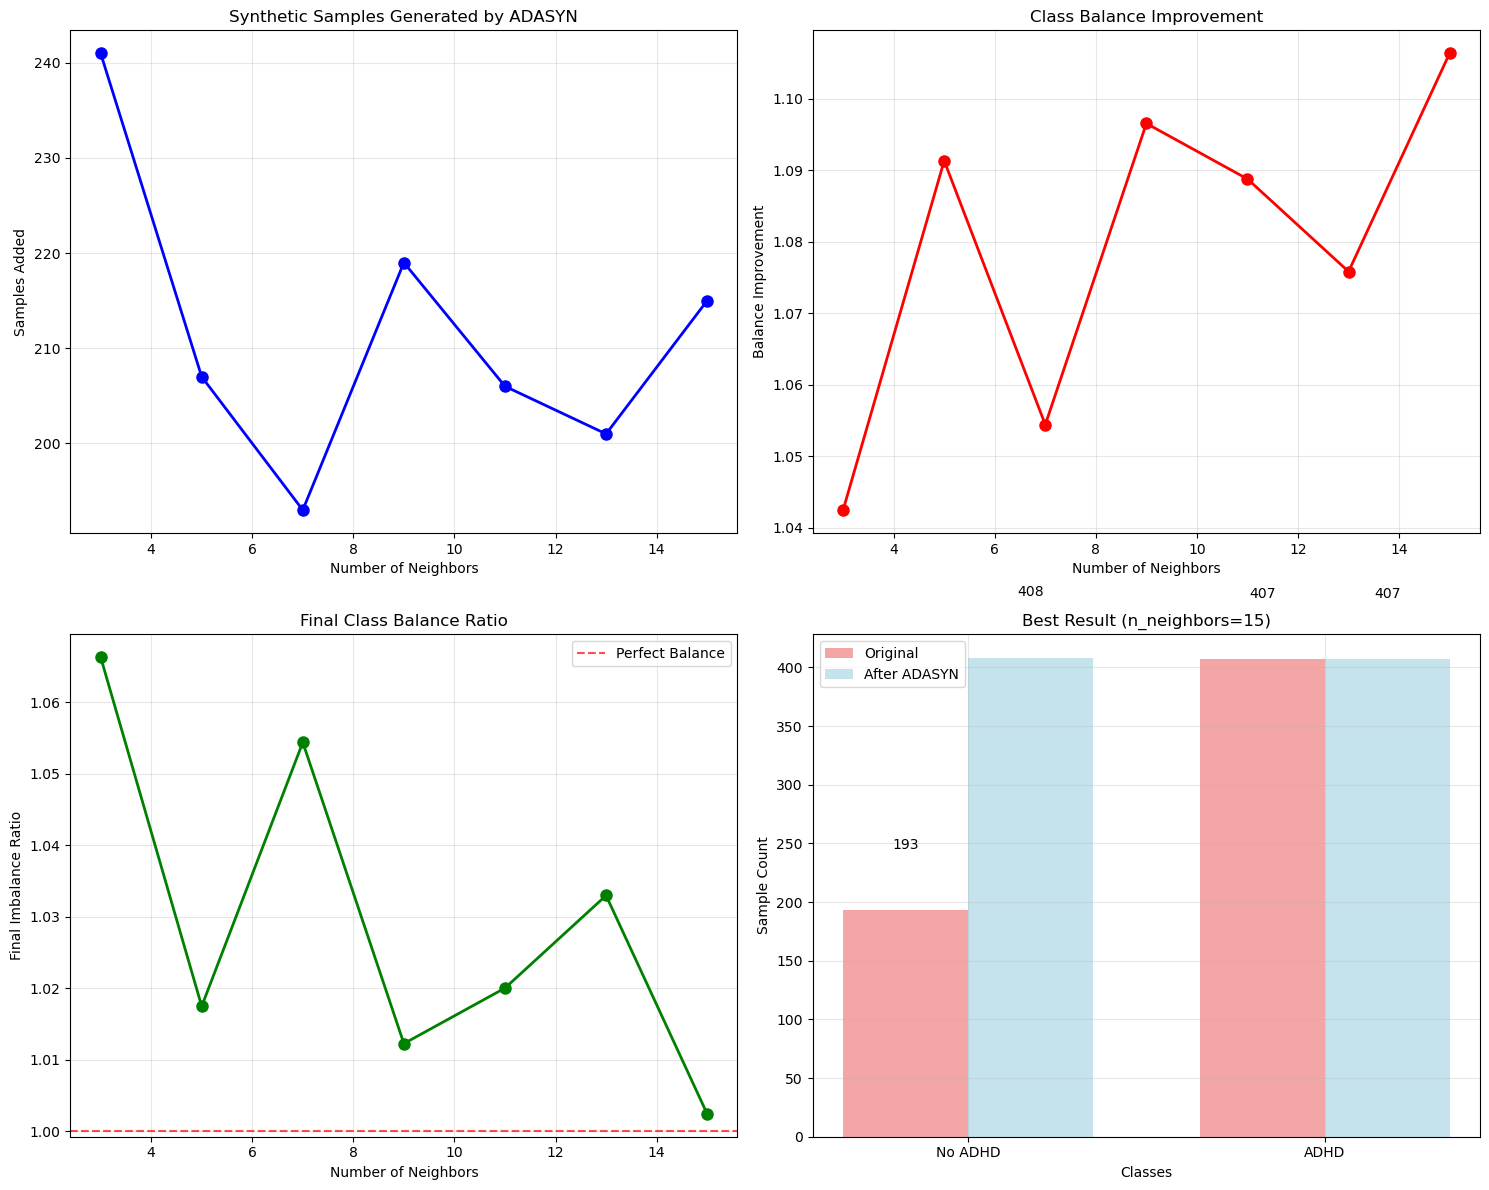


BEST NEIGHBOR VALUES:
      📈 By Balance Improvement:
         1. n_neighbors=15: improvement=1.106
         2. n_neighbors=9: improvement=1.097
         3. n_neighbors=5: improvement=1.091
 By Final Balance (closest to 1:1):
         1. n_neighbors=15: ratio=1.002
         2. n_neighbors=9: ratio=1.012
         3. n_neighbors=5: ratio=1.018

🎯 STEP 3: Applying Optimal ADASYN to Training Data
   🎯 Selected optimal n_neighbors: 15
      • Achieves ratio: 1.002:1
🎯 APPLYING OPTIMAL ADASYN (n_neighbors=15)
   📊 Original Training Distribution: {0: 193, 1: 407}
   📈 Training Set Shape: (600, 756)
   ✅ ADASYN Applied Successfully!
      📈 New Distribution: {0: 408, 1: 407}
      📊 Samples Added: 215
      📊 Original Size: 600
      📊 New Size: 815
      📈 Size Increase: 35.8%
   📊 Balance Analysis:
      • Original Imbalance Ratio: 2.109:1
      • New Imbalance Ratio: 1.002:1
      • Balance Improvement: 1.106

📊 STEP 4: Final Comparison


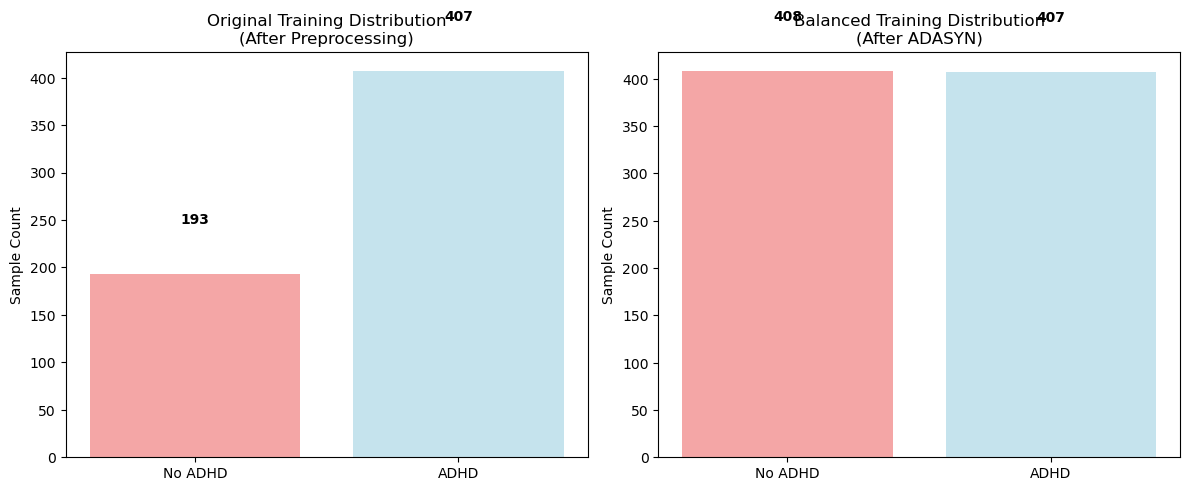


🎉 ADASYN BALANCING COMPLETE!
   📊 Final dataset splits for modeling:
      • X_train_balanced: (815, 756) (✅ Ready for training)
      • X_val (unchanged): (200, 756) (✅ No data leakage)
      • X_test (unchanged): (201, 756) (✅ No data leakage)

🔄 Updating training data variables...
   ✅ X_train and y_train updated with balanced data
   📊 New training set: (815, 756)
   🎯 New training distribution: {0: 408, 1: 407}

💾 FINAL DATASET SUMMARY:
   🎯 Training (balanced): X_train(815, 756), y_train(815,)
   📊 Validation: X_val(200, 756), y_val(200,)
   📊 Test: X_test(201, 756), y_test(201,)
   ✅ Ready for model training!


In [ ]:
print("STEP 1: Experimenting with ADASYN Parameters on Preprocessed Data")
print("=" * 60)

# Run ADASYN neighbor experimentation on preprocessed training data
experiment_results = experiment_adasyn_neighbors(
    X_train, y_train,  
    neighbor_range=(3, 16),  # Test n_neighbors = 3, 5, 7, 9, 11, 13, 15
    step=2,
    random_state=42
)

# STEP 2: Visualize experiment results
print("\nSTEP 2: Analyzing Experiment Results")
visualize_adasyn_experiments(experiment_results)

# STEP 3: Apply the best ADASYN configuration to full training data
print("\nSTEP 3: Applying Optimal ADASYN to Training Data")

# Filter only successful experiments
successful_results = {k: v for k, v in experiment_results.items() if v.get('success', False)}

if successful_results:
    # Choose n_neighbors that yields the closest ratio to 1.0 (perfect balance)
    optimal_neighbors = min(
        successful_results.keys(), 
        key=lambda k: abs(successful_results[k]['new_ratio'] - 1.0)
    )

    print(f"   Selected optimal n_neighbors: {optimal_neighbors}")
    print(f"      Final class ratio: {successful_results[optimal_neighbors]['new_ratio']:.3f}:1")
    
    # Apply ADASYN with optimal parameters
    X_train_balanced, y_train_balanced, adasyn_model = apply_optimal_adasyn_fixed(
        X_train, y_train,
        optimal_neighbors=optimal_neighbors,
        random_state=42
    )

    # STEP 4: Visual comparison before and after balancing
    print("\nSTEP 4: Final Class Distribution Comparison")

    plt.figure(figsize=(12, 5))

    # Plot original training distribution
    plt.subplot(1, 2, 1)
    original_counts = Counter(y_train)
    plt.bar(['Class 0', 'Class 1'], 
            [original_counts[0], original_counts[1]], 
            color=['lightcoral', 'lightblue'], alpha=0.7)
    plt.title('Original Training Distribution (After Preprocessing)')
    plt.ylabel('Sample Count')
    for i, count in enumerate([original_counts[0], original_counts[1]]):
        plt.text(i, count + 50, f'{count:,}', ha='center', va='bottom')

    # Plot balanced training distribution
    plt.subplot(1, 2, 2)
    balanced_counts = Counter(y_train_balanced)
    plt.bar(['Class 0', 'Class 1'], 
            [balanced_counts[0], balanced_counts[1]], 
            color=['lightcoral', 'lightblue'], alpha=0.7)
    plt.title('Balanced Training Distribution (After ADASYN)')
    plt.ylabel('Sample Count')
    for i, count in enumerate([balanced_counts[0], balanced_counts[1]]):
        plt.text(i, count + 50, f'{count:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print("\nADASYN balancing complete.")
    print("Final dataset status:")
    print(f"   X_train_balanced: {X_train_balanced.shape}")
    print(f"   X_val (unchanged): {X_val.shape}")
    print(f"   X_test (unchanged): {X_test.shape}")
    
    # Update training data
    print("\nUpdating training data with balanced dataset...")
    X_train = X_train_balanced.copy()
    y_train = y_train_balanced.copy()
    print(f"   Updated training data shape: {X_train.shape}")
    print(f"   Updated target distribution: {dict(Counter(y_train))}")

else:
    print("No successful ADASYN experiments. Using original preprocessed training data.")

print("\nFINAL DATASET SUMMARY:")
print(f"   Training (balanced): X_train{X_train.shape}, y_train{y_train.shape}")
print(f"   Validation: X_val{X_val.shape}, y_val{y_val.shape}")
print(f"   Test: X_test{X_test.shape}, y_test{y_test.shape}")
print("   Dataset is ready for model training.")


## Save preprocessed data 

In [17]:
import joblib

joblib.dump(X_train, 'X_train_balanced.pkl')
joblib.dump(y_train, 'y_train_balanced.pkl')
joblib.dump(X_val, 'X_val_processed.pkl')
joblib.dump(y_val, 'y_val.pkl')
joblib.dump(X_test, 'X_test_processed.pkl')
joblib.dump(y_test, 'y_test.pkl')


['y_test.pkl']

In [18]:


# Save the final balanced training data
X_train_balanced = pd.DataFrame(X_train)  # Ensure it's a DataFrame
y_train_balanced = pd.Series(y_train)     # Ensure it's a Series

# Combine X and y for easier loading in EDA
balanced_train_df = X_train_balanced.copy()
balanced_train_df['ADHD_Outcome'] = y_train_balanced.values

# Save to CSV
balanced_train_df.to_csv('balanced_train_data.csv', index=False)

# Done